- **This code is a preparation for computing the CL-DRTO solution using a scenario-based stochastic programming approach and its implementation in the plant.**

Here, we code:
- Decrease the size of the finite element of the backward Euler method while keeping the input discretization the same 
- Compare the solution with an ODE integrator
- Apply the changes to a CLDRTO implementarion (using input clipping)

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: August 2023

[1. Model and Simulation Parameters](#sec1) <br>
[2. Optimizing dynamic model using Backward Euler](#sec2) <br>
[3. Integrating dynamic model using ODE](#sec3) <br>
[4. CLDRTO Dynamic optimization test](#sec4) <br>

In [1]:
using LinearAlgebra, JuMP, Ipopt, Plots, DifferentialEquations

<a id="sec1"></a>

# Model and simulation parameter

- Simulation parameters

In [2]:
# Simulation sampling time
dt = 0.5 #[s]

# Plant simulation time span
tspan = (0.0,dt)

# Optimization horizon
ndrto = 10 # dt_DRTO

# integration (BE) sampling time
n_fe_dt = 5 # number of finite elements/simulation sampling time 

# finite element length
h = dt/n_fe_dt 

# number of finite elements 
nfe = ndrto*n_fe_dt

# Optimization horizon
Δdrto = 4*n_fe_dt # dt_DRTO

# number of components
nc = 3 #[-]
# number of inputs
nu = 2 #[-]
# number of reactors
nrt = 2 #[-]
# number of reactions
nrc = 2 #[-]
# number of MPCs
numpc = 2 

# initial value
C0 = [0.124287 0.216517;
    19.725 19.659;
    0.150668 0.124504]
T0 = [341.7216268417903 331.0792925101132]

# "algebraic states"
C_in0 = [20.0 10.0621;
          0 9.86252;
          0 0.0753341]
T_in0 = [299.99999999998846 320.8608134932841]
Tj_out0 = [316.6886507367161 297.43171700404525]

# "inputs"
Q0 = 0.2
Qm0 = 0.2

# initial value of u
u0 = [Q0 Qm0]

# States (algebraic and differential): CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out
x0 = [C0[1,1], C0[2,1], C0[3,1],T0[1],Tj_out0[1],C0[1,2], C0[2,2], C0[3,2],T0[2],Tj_out0[2]];

- Model Parameters

In [3]:
# feed to reactor 1 concentrations c = (A,B,C)
C1_in = [20.0, 0, 0] #[kmol/m3]

# temperature of feed to reactor 1
T1_in = 300.0 #[K]

# feed to mixer concentration c = (A,B,C)
Cm_in = [20.0, 0, 0]

# temperature of feed to mixer
Tm_in = 300.0 #[K]

# feed flowrate of cooling water to reactor jacket r = (1,2)
Qj_in = [0.7, 0.7] #[m3/s]

# cooling water temperature to reactor jacket r = (1,2)
Tj_in = [300.0, 275.0] #[m3/s]

# reactor volumetric holdup r = (1,2)
V = [5.0, 5.0] #[m3]

# heat transfer coefficient
Ua = [0.35, 0.35] #[m3/s]

# reaction rate constant e = (I,II)
k0 = [2.7e8, 160.0] #[1/s]

# reaction activation energy e = (I,II)
ER = [6000.0, 4500.0] #[K]

# heat of reaction e = (I,II)
dH_pcp = -[5.0, 5.0] #[m3 K/kmol] 

# stochiometric matrix 
Ms = [-1 0;
       1 -1;
       0 1];

- Economic Optimization Problem Parameters

In [4]:
# feed supply limitation
Qf_max = 0.8 #[m3/s] 

# safety restriction (avoiding temperature run away) -- (350)
Tr_max = 360 #[K]

# product specifications
cA2_max = 0.3 #[kmol/m3]

# max cooling water outlet temperature r = (1,2) ([340, 310])
Tj_max = [340, 310] #[K]

# min feed to reactor 1
Q_min = 0.05 #[m3/s]

# min feed to mixer
Qm_min = 0.05 #[m3/s]

# Output bounds (T1, T2)
yMin = [100.0 100.0] #K
yMax = [350.0 350.0] #K

# Setpoint bounds (T1, T2)
yspMin = [100.0 100.0] #K
yspMax = [360.0 360.0] #K

# Input bounds (Q1, Qm)
uMin = [0.050 0.050] #K
uMax = [0.805 0.800]; #K

- Steady-state optimal solution

In [5]:
# concentration related variables
C0_star = [0.114545 0.174342;
    19.7379 19.6938;
    0.147529 0.13187]

T0_star = [350.00000000404816 337.5000000227455]
T_in0_star = [300.0 327.5923855099112]
Tj_out0_star = [320.00000000161924 300.0000000090982]
Q0_star = [0.27907949788513375 0.5057183218310063]
Qm0_star = 0.22663882394587254

solSS = Dict('C' => C0_star,
             'T' => T0_star,
             'I' => T_in0_star, 
             'J' => Tj_out0_star,
             'Q' => Q0_star,
             'M' => Qm0_star);

- Preparing Orthogonal Collocation

In [6]:
# Parameters for orthogonal collocation
#  Radau Collocation Points 1st degree polynomial == Backward Euler
radau  = [0.0 1.00000]

# number of collocation points (initial point is also considered)
ncp = length(radau) 

# Collocation parameters and radau time series
colmat = [-1.0 -1.0;
          1.0 1.0];        

<a id="sec3"></a>

# Integrating model using ODE Integrator

Preparing integrator

In [7]:
function twoCSTRS_dae!(dx, x, p, t)
    CA1,CB1,CC1,T1,Tj1_out,CA2,CB2,CC2,T2,Tj2_out = x
    Q1,Qm = p
    
    # reactor 1
    dx[1] = (C1_in[1] - CA1)*Q1/V[1] - k0[1]*exp(-ER[1]/T1)*CA1 
    dx[2] = (C1_in[2] - CB1)*Q1/V[1] + k0[1]*exp(-ER[1]/T1)*CA1 - k0[2]*exp(-ER[2]/T1)*CB1
    dx[3] = (C1_in[3] - CC1)*Q1/V[1] + k0[2]*exp(-ER[2]/T1)*CB1
    dx[4] = (T1_in - T1)*Q1/V[1] - dH_pcp[1]*k0[1]*exp(-ER[1]/T1)*CA1 - dH_pcp[2]*k0[2]*exp(-ER[2]/T1)*CB1 - Ua[1]*(T1 - (0.5*(Tj1_out + Tj_in[1])))/V[1]
    dx[5] = Qj_in[1]*(Tj1_out - Tj_in[1]) - Ua[1]*(T1 - (0.5*(Tj1_out + Tj_in[1])))
    # reactor 2
    dx[6] = ((Q1*CA1 + Qm*Cm_in[1])/(Q1 + Qm) - CA2)*(Q1 + Qm)/V[2] - k0[1]*exp(-ER[1]/T2)*CA2 
    dx[7] = ((Q1*CB1 + Qm*Cm_in[2])/(Q1 + Qm) - CB2)*(Q1 + Qm)/V[2] + k0[1]*exp(-ER[1]/T2)*CA2 - k0[2]*exp(-ER[2]/T2)*CB2 
    dx[8] = ((Q1*CC1 + Qm*Cm_in[3])/(Q1 + Qm) - CC2)*(Q1 + Qm)/V[2] + k0[2]*exp(-ER[2]/T2)*CB2 
    dx[9] = ((Q1*T1 + Qm*Tm_in)/(Q1 + Qm) - T2)*(Q1 + Qm)/V[2] - dH_pcp[1]*k0[1]*exp(-ER[1]/T2)*CA2 - dH_pcp[2]*k0[2]*exp(-ER[2]/T2)*CB2 - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))/V[2]
    dx[10] = Qj_in[2]*(Tj2_out - Tj_in[2]) - Ua[2]*(T2 - (0.5*(Tj2_out + Tj_in[2])))
    
    nothing
end

# mass matrix to determine algebraic equations
M = [1. 0 0 0 0 0 0 0 0 0;
     0 1. 0 0 0 0 0 0 0 0;
     0 0 1. 0 0 0 0 0 0 0;
     0 0 0 1. 0 0 0 0 0 0;
     0 0 0 0 0 0 0 0 0 0;
     0 0 0 0 0 1. 0 0 0 0;
     0 0 0 0 0 0 1. 0 0 0;
     0 0 0 0 0 0 0 1. 0 0;
     0 0 0 0 0 0 0 0 1. 0;
     0 0 0 0 0 0 0 0 0 0]

ode_fun_mm = ODEFunction(twoCSTRS_dae!,mass_matrix=M);

<a id="sec4"></a>

# Adding finer discretization to CLDRTO

- Parameters

In [8]:
##########
# MODELS #
##########
# reference for deviation variables
# MPC 1
T1_0_bar = 350.00000000404816
Q1_0_bar = 0.27907949788513375

# MPC 2
T2_0_bar = 337.5000000227455
Qm_0_bar = 0.22663882394587254

yref = [T1_0_bar T2_0_bar]
uref = [Q1_0_bar Qm_0_bar]

# Linear SISO model coefficients
# MPC1
a1_hat = 0.9444968979045645
b1_hat = 4.755754997301486

# MPC2
a2_hat = 0.9256356006985642
b2_hat = 5.70696857693315

# initial value of xMPC
xMPC0 = [T0[1] - T1_0_bar, T0[2] - T2_0_bar]
de_0 = [0.0 0.0] # known initial states

##########
# TUNING #
##########
# prediction horizon 
p = 5

# control horizon 
m = 3

# output tracking weight
q = 1

# move supression weight
r = [150,500]

# input bounds
u_mpc_lb = 0.05
u_mpc_ub = 0.8

u_cldrto_lb = u_mpc_lb .- uref
u_cldrto_ub = u_mpc_ub .- uref;

- Auxiliary Functions

In [9]:
function MPC_matrices(A,B,C,p,m,q,r)
    ###########
    # inputs: #
    ###########
    # A,B,C - System model
    # p, m - prediction and control horizon
    # q, r - setpoint and input usage tuning parameters
    
    # extracting dimensions from system model
    nx = size(A,1) # states
    nu = size(B,2) # inputs
    ny = size(C,1) # outputs
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

In [10]:
function solveMPC(xkk,dekk,uk_1,yspk,umin,umax,yref,uref,mpc,p,m)
    ###########
    # inputs: #
    ###########
    # xkk - current states (MPC model) 
    # dekk - disturbance estimate 
    # uk_1 - inputs at the current iteration, already implemented on the plant
    # yspk - setpoint trajectory computed by CL-DRTO
    # umin, umax - input bounds
    # yref, uref - reference points for computing deviation variables
    # mpcModel - System model
    # p, m - prediction and control horizon
    
    MPC_con = Model(Ipopt.Optimizer)
    set_silent(MPC_con)
    
    ####################
    # Set up variables #
    ####################
    # inputs computed by MPCs
    @variable(MPC_con, (umin - uref) ≤ u[1:m] ≤ (umax - uref))
    
    ######################
    # Set up expressions #
    ######################
    @expression(MPC_con, cfT, (mpc['Ψ']*[xkk;dekk] .- (yspk - yref))'*mpc['Q']*mpc['Θ'] - (uk_1 - uref)'*mpc['I']'*mpc['R']*mpc['M'])
    
    
    # Option 1. solving as a constrained MPC
    @objective(MPC_con, Min, sum(u[jj]*sum(mpc['H'][jj,ii]*u[ii] for ii in 1:m) for jj in 1:m) + 2*sum(cfT[jj]*u[jj] for jj = 1:m))

    # Option 2. solving exactly like in the CLDRTO implementation (for debugging)
    #@constraint(MPC_con, MPCsol[jj = 1:m], sum(mpc['H'][jj,ii]*u[ii] for ii in 1:m) + cfT[jj] == 0.0)    
    #@objective(MPC_con, Min, -1)

    #################
    # Solve Problem #
    #################
    optimize!(MPC_con)
    
    if has_values(MPC_con)
        flag = 1
    else
        flag = 0
    end

    #calling values of the solved problem
    ϕ = objective_value(MPC_con)
    uArray = value.(u) .+ uref
    return Dict('ϕ' => ϕ,'u' => uArray, 'f' => flag)
end;

In [11]:
function CL_DRTO(C_0,T_0,u_0,xMPC_0,de_0)    
    ###########
    # inputs: #
    ###########
    # yspFixed - setpoints determined by the master problem 
    # C_0, T_0 - concentration and temperature states at the current iteration (beginning of DRTO horizon)
    # u_0 - current input implemented in the plant
    # xMPC_0 - current MPC states
    # de_0 - current plant/MPC model deviation
    
    # JuMP model
    model_sub = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model_sub, "warm_start_init_point", "yes")
    set_optimizer_attribute(model_sub, "print_level", 5)
    set_optimizer_attribute(model_sub, "max_cpu_time", 300.0) # 5 min
    set_silent(model_sub)

    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_sub, C[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0)           # [kmol/m3] concentration (diff states)
    @variable(model_sub, T[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
    @variable(model_sub, J[1:nfe, 1:ncp])                            # [$] objective function (diff states)
    @variable(model_sub, Cdot[1:nc, 1:nrt, 1:nfe, 1:ncp])            # [kmol/m3/s] concentration (time derivative)
    @variable(model_sub, Tdot[1:nrt, 1:nfe, 1:ncp])                  # [K/s] reactor temperature (time derivative)
    @variable(model_sub, Jdot[1:nfe, 1:ncp])                         # [$/s] objective function (time derivative
    @variable(model_sub, Tj_out[rt=1:nrt, 1:nfe, 1:ncp] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
    @variable(model_sub, C_in[1:nc, 1:nrt, 1:nfe, 1:ncp] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
    @variable(model_sub, T_in[rt=1:nrt, 1:nfe, 1:ncp])   # [K] inlet temperature (alg. states)
    #@variable(model_sub, Q_min ≤ Q[1:nrt, 1:ndrto] ≤ Qf_max)           # [m3/s] flowrate to reactor
    #@variable(model_sub, Qm_min ≤ Qm[1:ndrto] ≤ Qf_max)                # [m3/s] flowrate to mixer
    @variable(model_sub, Q[1:nrt, 1:ndrto])           # [m3/s] flowrate to reactor
    @variable(model_sub, Qm[1:ndrto])                # [m3/s] flowrate to mixer

    # MPC model variables (SISO) -> deviation form
    @variable(model_sub, xMPC[1:numpc, 1:ndrto])
    @variable(model_sub, uMPC[1:numpc, 1:ndrto, 1:m])
    @variable(model_sub, uMPC_w_c[1:numpc,1:ndrto,1:m]) # inputs w/o clipping

    # input clipping 
    @variable(model_sub, mu_lb[1:numpc,1:ndrto,1:m] ≥ 0.0)
    @variable(model_sub, eta_lb[1:numpc,1:ndrto,1:m] ≥ 0.0)
    @variable(model_sub, mu_ub[1:numpc,1:ndrto,1:m] ≥ 0.0)
    @variable(model_sub, eta_ub[1:numpc,1:ndrto,1:m] ≥ 0.0)
    
    # MPC <-> DRTO model deviation
    @variable(model_sub, de[1:numpc,1:(ndrto - 1)])

    # setpoints for the controllers sent to the plant (*CL-DRTO degrees of freedom)
    @variable(model_sub, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto] ≤ yspMax[nct])

    #####################################
    # Set up initial guesses for solver #
    #####################################
    # Set up initial guesses for solver: using opt. steady-state previoulsy computed
    for kk in 1:nfe
        for jj in 1:ncp
            for rr in 1:nrt
                for cc in 1:nc
                    # concentration related variables
                    set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                    set_start_value(C[cc,rr,kk,jj], C0_star[cc,rr]) 
                end # components loop

                # temperature related variables
                set_start_value(T[rr,kk,jj], T0_star[rr]) 
                set_start_value(T_in[rr,kk,jj], T_in0_star[rr])
                set_start_value(Tj_out[rr,kk,jj], Tj_out0_star[rr])

            end # reactors loop
        end # collocation points loop
    end
    
    for kk in 1:ndrto
        # MV's
        for rr in 1:nrt
            set_start_value(Q[rr,kk], Q0_star[rr])  
        end
        set_start_value(Qm[kk], Qm0_star) 

        for mm in 1:m
            set_start_value(uMPC[1,kk,mm], Q0_star[1] - uref[1])
            set_start_value(uMPC[2,kk,mm], Qm0_star - uref[2])
        end
    end # finite elements loop
    
    ##############
    # DRTO model #
    ##############
    @NLexpressions(model_sub, begin
            # [1/s] reaction rate
            k[rt = 1:nrt, rc = 1:nrc, kk = 1:nfe, jj = 1:ncp], k0[rc]*exp(-ER[rc]/T[rt,kk,jj])
            #[m3 K/s] cooling rate
            # approximate model *approximating logarithm temperature
            qcool[rt = 1:nrt,kk = 1:nfe, jj = 1:ncp], Ua[rt]*(T[rt,kk,jj] - (0.5*(Tj_out[rt,kk,jj] + Tj_in[rt])))
    end)

    @NLconstraints(model_sub, begin
            #########
            # MODEL #
            #########    
            # reactor
            r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:nfe, jj = 1:ncp], Cdot[co,rt,kk,jj] == (C_in[co,rt,kk,jj] - C[co,rt,kk,jj])*Q[rt,cld(kk,n_fe_dt)]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) 
            r_eb[rt = 1:nrt, kk = 1:nfe, jj = 1:ncp], Tdot[rt,kk,jj] == (T_in[rt,kk,jj] - T[rt,kk,jj])*Q[rt,cld(kk,n_fe_dt)]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj]*C[rc,rt,kk,jj] for rc in 1:nrc) - qcool[rt,kk,jj]/V[rt]
            # mixer
            m_mb[kk = 1:ndrto], 0 == Q[1,kk] + Qm[kk] - Q[2,kk]
            m_cmb[co = 1:nc,kk = 1:nfe,jj = 1:ncp], 0 == Q[1,cld(kk,n_fe_dt)]*C[co,1,kk,jj] + Qm[cld(kk,n_fe_dt)]*Cm_in[co] - Q[2,cld(kk,n_fe_dt)]*C_in[co,2,kk,jj]
            m_eb[kk = 1:nfe,jj = 1:ncp], 0 == Q[1,cld(kk,n_fe_dt)]*T[1,kk,jj] + Qm[cld(kk,n_fe_dt)]*Tm_in - Q[2,cld(kk,n_fe_dt)]*T_in[2,kk,jj]
            # jacket
            j_eb[rt = 1:nrt,kk = 1:nfe,jj = 1:ncp], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj] - Tj_in[rt]) - qcool[rt,kk,jj]
            # objective function
            JInteg[kk = 1:nfe, jj = 1:ncp], Jdot[kk,jj] == 10*(Q[1,cld(kk,n_fe_dt)]*C_in[1,1,kk,jj] + Qm[cld(kk,n_fe_dt)]*Cm_in[1] - Q[2,cld(kk,n_fe_dt)]*(C[1,2,kk,jj] + C[3,2,kk,jj])) - 0.01*qcool[1,kk,jj] - qcool[2,kk,jj] - 0.1*Q[1,cld(kk,n_fe_dt)] - 0.1*Qm[cld(kk,n_fe_dt)]

            #########################    
            # Collocation Equations #    
            #########################
            # initial point
            coll_C_0[co=1:nc, rt = 1:nrt], C[co,rt,1,1] == C_0[co,rt] 
            coll_T_0[rt = 1:nrt], T[rt,1,1] == T_0[rt]
            coll_J_0, J[1,1] == 0 
            
            # set up collocation equations 
            coll_C_n[co = 1:nc, rt = 1:nrt, kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*C[co,rt,kk,ii] for ii in 1:ncp) - h*Cdot[co,rt,kk,jj] == 0 
            coll_T_n[rt = 1:nrt, kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*T[rt,kk,ii] for ii in 1:ncp) - h*Tdot[rt,kk,jj] == 0
            coll_J_n[kk = 1:nfe, jj = 2:ncp], sum(colmat[ii,jj]*J[kk,ii] for ii in 1:ncp) - h*Jdot[kk,jj] == 0

            # continuinity equations
            coll_C_con[co = 1:nc, rt = 1:nrt, kk = 2:nfe], C[co,rt,kk,1] - C[co,rt,kk - 1,ncp] == 0 
            coll_T_con[rt = 1:nrt, kk = 2:nfe], T[rt,kk,1] - T[rt,kk - 1,ncp] == 0
            coll_J_con[kk = 2:nfe], J[kk,1] - J[kk - 1,ncp] == 0
    end)
    
    ##########################
    # MPC model and solution #
    ##########################
    # N.B. inside MPC everything is in deviation variables
    @expressions(model_sub, begin
            # MPC1
            cfT_c1_1, (mpc1['Ψ']*[xMPC_0[1];de_0[1]] .- (ysp[1,1] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u_0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
            cfT_c1[kk=1:(ndrto - 1)], (mpc1['Ψ']*[xMPC[1,kk];de[1,kk]] .- (ysp[1,kk + 1] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC_w_c[1,kk,1]*mpc1['I']'*mpc1['R']*mpc1['M']
            # MPC2
            cfT_c2_1, (mpc2['Ψ']*[xMPC_0[2];de_0[2]] .- (ysp[2,1] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u_0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
            cfT_c2[kk=1:(ndrto - 1)], (mpc2['Ψ']*[xMPC[2,kk];de[2,kk]] .- (ysp[2,kk + 1] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC_w_c[2,kk,1]*mpc2['I']'*mpc2['R']*mpc2['M']
    end)

    @constraints(model_sub, begin
            #############
            # MPC model #
            #############
            # MPC1
            MPC1_dyn_model_1, xMPC[1,1] == mpc1['A']*xMPC_0[1] + mpc1['B']*uMPC_w_c[1,1,1]
            MPC1_dyn_model[kk = 1:(ndrto - 1)], xMPC[1,kk + 1] == mpc1['A']*xMPC[1,kk] + mpc1['B']*uMPC_w_c[1,kk + 1,1]
            MPC1_model_dev[kk=1:(ndrto - 1)], de[1,kk] == T[1,kk*n_fe_dt,ncp] - (xMPC[1,kk] + yref[1])
            # MPC12
            MPC2_dyn_model_1, xMPC[2,1] == mpc2['A']*xMPC_0[2] + mpc2['B']*uMPC_w_c[2,1,1]
            MPC2_dyn_model[kk = 1:(ndrto - 1)], xMPC[2,kk + 1] == mpc2['A']*xMPC[2,kk] + mpc2['B']*uMPC_w_c[2,kk + 1,1]
            MPC2_model_dev[kk=1:(ndrto - 1)], de[2,kk] == T[2,kk*n_fe_dt,ncp] - (xMPC[2,kk] + yref[2])
    end)
    
    @constraints(model_sub, begin
        ################
        # MPC solution #
        ################
        # MPC1
        MPC1_sol_1[uu = 1:m], sum(mpc1['H'][uu,ii]*uMPC_w_c[1,1,ii] for ii in 1:m) + cfT_c1_1[uu] == 0.0    
        MPC1_sol[kk=1:(ndrto - 1),uu = 1:m], sum(mpc1['H'][uu,ii]*uMPC_w_c[1,kk + 1,ii] for ii in 1:m) + cfT_c1[kk][uu] == 0.0    
        # MPC2
        MPC2_sol_1[uu = 1:m], sum(mpc2['H'][uu,ii]*uMPC_w_c[2,1,ii] for ii in 1:m) + cfT_c2_1[uu] == 0.0    
        MPC2_sol[kk=1:(ndrto - 1),uu = 1:m], sum(mpc2['H'][uu,ii]*uMPC_w_c[2,kk + 1,ii] for ii in 1:m) + cfT_c2[kk][uu] == 0.0         
    end)
    
    @constraints(model_sub, begin
        ##################
        # Input clipping #
        ##################
        ic_1[nct = 1:numpc, kk = 1:ndrto,uu = 1:m], uMPC[nct,kk,uu] == uMPC_w_c[nct,kk,uu] - mu_ub[nct,kk,uu] + mu_lb[nct,kk,uu]
        ic_2[nct = 1:numpc, kk = 1:ndrto,uu = 1:m], (uMax[nct] - uref[nct]) - uMPC[nct,kk,uu] == eta_ub[nct,kk,uu]
        ic_3[nct = 1:numpc, kk = 1:ndrto,uu = 1:m], eta_ub[nct,kk,uu]*mu_ub[nct,kk,uu] ≤ 1e-6
        ic_4[nct = 1:numpc, kk = 1:ndrto,uu = 1:m], uMPC[nct,kk,uu] - (uMin[nct] - uref[nct]) == eta_lb[nct,kk,uu]
        ic_5[nct = 1:numpc, kk = 1:ndrto,uu = 1:m], eta_lb[nct,kk,uu]*mu_lb[nct,kk,uu] ≤ 1e-6         
    end)
      
    @constraints(model_sub, begin   
            #######################
            # PROCESS CONSTRAINTS #
            #######################
            # ! Enforcing only at the end of the finite element
            # safety restrictions
            g1[rt = 1:nrt, kk = 1:nfe], T[rt,kk,ncp] - Tr_max ≤ 0
            # product specifications (Concentration of A in reactor 2)
            g2[kk = 1:nfe], C[1,2,kk,ncp] - cA2_max ≤ 0
            # feed supply limitations
            g3[kk = 1:ndrto], Q[1,kk] + Qm[kk] - Qf_max ≤ 0
            # process limitations (others have been included when declaring variables): max cooling water outlet temperature
            g4[rt = 1:nrt, kk = 1:nfe], Tj_out[rt,kk,ncp] - Tj_max[rt] ≤ 0    
            ############################
            # OPTIMIZATION CONSTRAINTS #
            ############################
            # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
            h1[kk = 1:ndrto], (uMPC[1,kk,1] + uref[1]) - Q[1,kk] == 0
            h2[kk = 1:ndrto], (uMPC[2,kk,1] + uref[2]) - Qm[kk] == 0
            ##############    
            # PARAMETERS #
            ##############
            p1[co = 1:nc,kk = 1:nfe,jj = 1:ncp], C_in[co,1,kk,jj] - C1_in[co] == 0
            p2[kk = 1:nfe,jj = 1:ncp], T_in[1,kk,jj] - T1_in == 0.0
        end)
    
    # Set up objective function  
    @NLobjective(model_sub, Min, -J[nfe,ncp])
    
    #################
    # Solve Problem #
    #################    
    optimize!(model_sub)
    
    # solution time
    timeSol = solve_time(model_sub)
    
    status = termination_status(model_sub)
    #display(status)
    
    # Proved optimality or Optimal within relaxed tolerances
    # we add an optimality cut
    flag = 1
    # #primal_status(m)

    #calling values of the solved problem
    ϕ = objective_value(model_sub)
    yspArray = value.(ysp)
    CArray = value.(C)
    TArray = value.(T)
    TjArray = value.(Tj_out)
    TinArray = value.(T_in)
    QArray = value.(Q)
    QmArray = value.(Qm)
    deArray = value.(de)
    xArray = value.(xMPC)

    outputDict = Dict('ϕ' => ϕ,
                    't' => timeSol,
                    'f' => flag, 
                    'a' => status,
                    's' => yspArray,
                    'Q' => QArray,
                    'M' => QmArray,
                    'C' => CArray,
                    'T' => TArray, 
                    'J' => TjArray,
                    'I' => TinArray,
                    'D' => deArray,
                    'X' => xArray)

    return outputDict
end;

Computing nominal solution

In [12]:
# building MPC's
# reactor 1 MPC: T1 <-> Q1
mpc1 = MPC_matrices(a1_hat,b1_hat,1,p,m,q,r[1])
# reactor 2 MPC: T2 <-> Qm
mpc2 = MPC_matrices(a2_hat,b2_hat,1,p,m,q,r[2]);


solNom = CL_DRTO(C0,T0,u0,xMPC0,de_0);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12369
Number of nonzeros in inequality constraint Jacobian.:      510
Number of nonzeros in Lagrangian Hessian.............:    11620

Total number of variables............................:     3248
                     variables with only lower bounds:     1840
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3108
Total number of inequality co

In [13]:
Cr_CL_be = Array{Float64}(undef,nc,nrt,nfe)
Tr_CL_be = Array{Float64}(undef,nrt,nfe)
Tj_CL_be = Array{Float64}(undef,nrt,nfe)
de_CL_be = Array{Float64}(undef,nrt,ndrto - 1)
x_CL_be = Array{Float64}(undef,nrt,ndrto)


# time series for plotting
t_be = Vector{Float64}(undef,nfe) 
for kk in 1:nfe
    t_be[kk] = h*kk
end

# time series for plotting
ysp_CL = solNom['s']
Q1_CL_be = solNom['Q'][1,:]
Qm_CL_be = solNom['M']

for rt in 1:nrt
    for co in 1:nc
        Cr_CL_be[co,rt,:] = solNom['C'][co,rt,:,ncp]
    end
    Tr_CL_be[rt,:] = solNom['T'][rt,:,ncp]
    Tj_CL_be[rt,:] = solNom['J'][rt,:,ncp]
    de_CL_be[rt,:] = solNom['D'][rt,:]
    x_CL_be[rt,:] = solNom['X'][rt,:]
end


## Comparing with ODE + controller results

In [14]:
# time series for plotting
t_integr = Vector{Float64}(undef,ndrto) 
for kk in 1:ndrto
    t_integr[kk] = dt*kk
end

# Extracting solution for plotting 
Cr_CL_integr = Array{Float64}(undef,nc,nrt,ndrto)
Tr_CL_integr = Array{Float64}(undef,nrt,ndrto)
Tj_CL_integr = Array{Float64}(undef,nrt,ndrto)
Q1_CL_integr = Array{Float64}(undef,ndrto)
Qm_CL_integr = Array{Float64}(undef,ndrto)
de_CL_integr = Array{Float64}(undef,nrt,ndrto)
x_CL_integr = Array{Float64}(undef,nrt,ndrto)

# preparing simulation (starting from opt steady-state)
# plant 
xk = x0
uk_1 = u0

# mpc's models - initial states is the same
xk_mpc1 = xMPC0[1]
dek_mpc1 = de_0[1]
xk_mpc2 = xMPC0[2]
dek_mpc2 = de_0[2]

for ii = 1:ndrto

    # solving MPC
    sol1 = solveMPC(xk_mpc1,dek_mpc1,uk_1[1],ysp_CL[1,ii],u_mpc_lb,u_mpc_ub,yref[1],uref[1],mpc1,p,m)
    sol2 = solveMPC(xk_mpc2,dek_mpc2,uk_1[2],ysp_CL[2,ii],u_mpc_lb,u_mpc_ub,yref[2],uref[2],mpc2,p,m)
    u1 = sol1['u'][1]
    u2 = sol2['u'][1]
    #u1 = Q1_CL_be[ii]
    #u2 = Qm_CL_be[ii]

    # evolving plant
    ode_prob_mm = ODEProblem(ode_fun_mm,xk,tspan,[u1 u2]);
    sol =  solve(ode_prob_mm, Rodas5(),reltol=1e-8,abstol=1e-8,save_everystep = false);

    # loop -> Plant 
    xk = sol.u[end]
    
    # -> MPCs
    # evolving MPC models
    xk_mpc1  = mpc1['A']*xk_mpc1 + mpc1['B']*(u1 - uref[1])
    dek_mpc1 = xk[4] - (xk_mpc1 + yref[1])

    xk_mpc2  =  mpc2['A']*xk_mpc2 + mpc2['B']*(u2 - uref[2])
    dek_mpc2 = xk[9] - (xk_mpc2 + yref[2])
    
    # saving data
    Cr_CL_integr[:,1,ii] = xk[1:3]
    Tr_CL_integr[1,ii] = xk[4]
    Tj_CL_integr[1,ii] = xk[5]
    Cr_CL_integr[:,2,ii] = xk[6:8]
    Tr_CL_integr[2,ii] = xk[9]
    Tj_CL_integr[2,ii] = xk[10]
    de_CL_integr[1,ii] = dek_mpc1
    de_CL_integr[2,ii] = dek_mpc2
    x_CL_integr[1,ii] = xk_mpc1
    x_CL_integr[2,ii] = xk_mpc2
    
    Q1_CL_integr[ii] = u1
    Qm_CL_integr[ii] = u2
    
    # loop
    uk_1 = [u1 u2]

end 

Plotting comparison

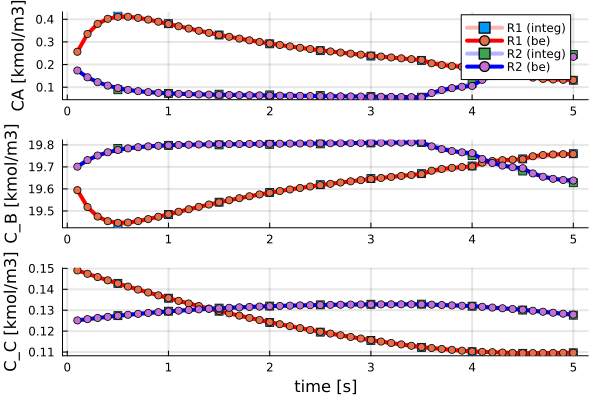

In [15]:
gr()

p11 = plot(t_integr,Cr_CL_integr[1,1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="CA [kmol/m3]")
p11 = plot!(t_be,Cr_CL_be[1,1,:],linewidth=4,linecolor = :red,marker=:circle)
p11 = plot!(t_integr,Cr_CL_integr[1,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p11 = plot!(t_be,Cr_CL_be[1,2,:],linewidth=4,linecolor = :blue,marker=:circle)

p11.series_list[1][:label] = "R1 (integ)"
p11.series_list[2][:label] = "R1 (be)"
p11.series_list[3][:label] = "R2 (integ)"
p11.series_list[4][:label] = "R2 (be)"

p12 = plot(t_integr,Cr_CL_integr[2,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="C_B [kmol/m3]",legend=false)
p12 = plot!(t_be,Cr_CL_be[2,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p12 = plot!(t_integr,Cr_CL_integr[2,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p12 = plot!(t_be,Cr_CL_be[2,2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

p13 = plot(t_integr,Cr_CL_integr[3,1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="C_C [kmol/m3]",legend=false)
p13 = plot!(t_be,Cr_CL_be[3,1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p13 = plot!(t_integr,Cr_CL_integr[3,2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p13 = plot!(t_be,Cr_CL_be[3,2,:],linewidth=4,linecolor = :blue,marker=:circle,xaxis="time [s]",legend=false)

g6 = plot(p11,p12,p13,layout=(3,1))
display(g6)

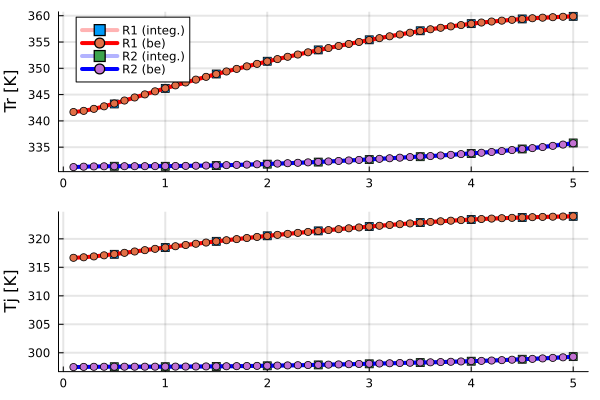

In [16]:
gr()

p14 = plot(t_integr,Tr_CL_integr[1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Tr [K]")
p14 = plot!(t_be,Tr_CL_be[1,:],linewidth=4,linecolor = :red,marker=:circle)
p14 = plot!(t_integr,Tr_CL_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue)
p14 = plot!(t_be,Tr_CL_be[2,:],linewidth=4,linecolor = :blue,marker=:circle)

p14.series_list[1][:label] = "R1 (integ.)"
p14.series_list[2][:label] = "R1 (be)"
p14.series_list[3][:label] = "R2 (integ.)"
p14.series_list[4][:label] = "R2 (be)"

p15 = plot(t_integr,Tj_CL_integr[1,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Tj [K]",legend=false)
p15 = plot!(t_be,Tj_CL_be[1,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)
p15 = plot!(t_integr,Tj_CL_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :blue,legend=false)
p15 = plot!(t_be,Tj_CL_be[2,:],linewidth=4,linecolor = :blue,marker=:circle,legend=false)

g7 = plot(p14,p15,layout=(2,1))
display(g7)

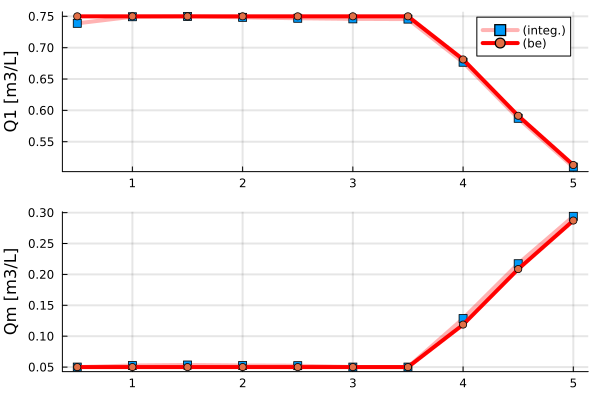

In [17]:
gr()

p16 = plot(t_integr,Q1_CL_integr,linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Q1 [m3/L]")
p16 = plot!(t_integr,Q1_CL_be,linewidth=4,linecolor = :red,marker=:circle)

p16.series_list[1][:label] = "(integ.)"
p16.series_list[2][:label] = "(be)"

p17 = plot(t_integr,Qm_CL_integr,linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="Qm [m3/L]",legend=false)
p17 = plot!(t_integr,Qm_CL_be,linewidth=4,linecolor = :red,marker=:circle,legend=false)

g8 = plot(p16,p17,layout=(2,1))
display(g8)

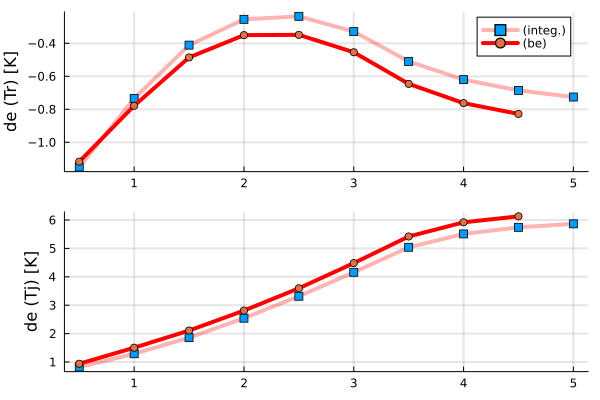

In [18]:
gr()

p18 = plot(t_integr,de_CL_integr[1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="de (Tr) [K]")
p18 = plot!(t_integr[1:end - 1],de_CL_be[1,:],linewidth=4,linecolor = :red,marker=:circle)

p18.series_list[1][:label] = "(integ.)"
p18.series_list[2][:label] = "(be)"

p19 = plot(t_integr,de_CL_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="de (Tj) [K]",legend=false)
p19 = plot!(t_integr[1:end - 1],de_CL_be[2,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)

g9 = plot(p18,p19,layout=(2,1))
display(g9)

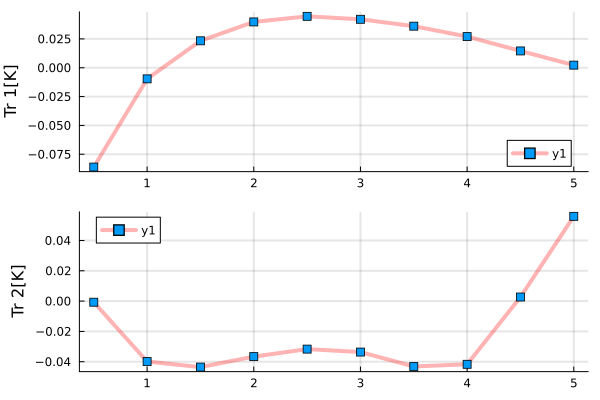

In [19]:
gr()

p22 = plot(t_integr,Tr_CL_integr[1,:] - Tr_CL_be[1,n_fe_dt:n_fe_dt:end],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Tr 1[K]")
p23 = plot(t_integr,Tr_CL_integr[2,:] - Tr_CL_be[2,n_fe_dt:n_fe_dt:end],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="Tr 2[K]")

g11 = plot(p22,p23,layout=(2,1))
display(g11)

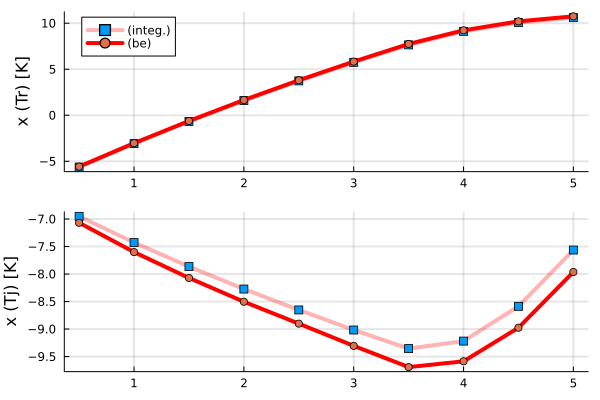

In [20]:
gr()

p20 = plot(t_integr,x_CL_integr[1,:],linewidth=4,linecolor = :red,marker=:square,linealpha = 0.3,gridlinewidth=2,yaxis="x (Tr) [K]")
p20 = plot!(t_integr,x_CL_be[1,:],linewidth=4,linecolor = :red,marker=:circle)

p20.series_list[1][:label] = "(integ.)"
p20.series_list[2][:label] = "(be)"

p21 = plot(t_integr,x_CL_integr[2,:],linewidth=4,linealpha = 0.3,marker=:square,linecolor = :red,gridlinewidth=2,yaxis="x (Tj) [K]",legend=false)
p21 = plot!(t_integr,x_CL_be[2,:],linewidth=4,linecolor = :red,marker=:circle,legend=false)

g10 = plot(p20,p21,layout=(2,1))